<a href="https://colab.research.google.com/github/jimjoseph51000/fpl-simulator/blob/main/simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [8]:
% cd /gdrive/MyDrive/CSE_519_DSF/gitcode/fpl-simulator-main/

/gdrive/MyDrive/CSE_519_DSF/gitcode/fpl-simulator-main


In [9]:
% ls

'CSE_519_DSF_Proposal___Fantasy_Premier_League (1).pdf'   Players_Weekwise/
'CSE_519___FPL_Progress_Report (1).pdf'                   player_types.csv
 fpl_mc_train.log                                         plots/
 LICENSE                                                 'Progress Report'/
 logs/                                                    __pycache__/
 model.py                                                 README.md
 models/                                                  readme_plot.png
 Player_Cost_Weekwise/                                   'Sanity Checker.ipynb'
'Player Embedding.ipynb'                                  scout.py
'Player Profiles.ipynb'                                   simulator.ipynb
 Player_Rankings/                                         simulator.py


In [10]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

from simulator import *
from model import *
from scout import * 
# from util import *

In [11]:

import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import namedtuple
from itertools import count

# Colab comes with PyTorch
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

import datetime
import copy

def random_action():
  idx = np.random.randint(N_actions)
  return possible_actions[idx], idx

def epsilon_greedy_action(env, state, model, epsilon, t):

  state = np.array(state) # (N_states,)
  assert(state.shape == (620,))
  assert(state.ndim == 1)
  # bp()
  week_vector = np.zeros(current_week)
  week_vector[t] = 1.0
  state = np.append(state, week_vector) # (630,)
  # we are gonna evaluate over all the different set of actions
  # print(possible_actions.shape) # (5,11)
  input = np.hstack((np.broadcast_to(state,(possible_actions.shape[0], state.shape[0])), possible_actions)) # (N_A,N_S+N_A)
  # print(input.shape)
  assert(input.shape == (N_actions, possible_actions.shape[1] + N_states + current_week)) # we are adding in the week vector too for now

  X = torch.from_numpy(input).float().cuda()
  model.eval()
  Y = model(X)
  assert(Y.shape == (N_actions,1))
  Y = Y.detach().cpu().numpy()
  best_idx = np.argmax(Y.reshape(-1))

  # you dont get to choose the best action. have soft probabilities based on exploration epsilon
  selection_prob_arr = np.zeros(N_actions, dtype=np.float)
  selection_prob_arr[:] = epsilon / N_actions
  selection_prob_arr[best_idx] = (epsilon / N_actions) + (1 - epsilon)
  # bp()
  assert(selection_prob_arr.sum().round() == 1.0)
  idx = np.random.choice(N_actions,1,replace=False, p = selection_prob_arr)
  # assert(idx.shape == (1,))
  model.train()
  # bp()
  # env.action_space.sample()
  return possible_actions[idx[0]], idx[0]

def calculate_episode_return(episode, gamma):
  episode = np.array(episode)
  assert(episode.ndim == 2)
  assert(episode.shape[0] == current_week)
  states_array = episode[:,0]
  # actions_array = episode[:,1]
  rewards_array = episode[:,2]
  # gamma_array = [gamma**i for i in range(episode.shape[0])]
  # Gt = rt + gamma * Gt\+1.
  # bp()
  G = np.array([0 for i in range(states_array.shape[0])], dtype = np.float)
  for i in range(G.shape[0]-1,-1,-1):
    # temp = G[i+1]
    if i == G.shape[0] - 1:
      temp = 0
    else:
      temp = G[i+1]
    G[i] = rewards_array[i] + gamma * temp
  # bp()
  # print(G)
  # assert(G[-1] == 1.0)
  return G


def update_Q_value(G, episode, model, optimizer):
  episode = np.array(episode)
  model = model.cuda()
  model.train()
  optimizer.zero_grad()
  loss_criterion = nn.MSELoss()
  # bp()
  action_arr = possible_actions[np.array(episode[:,1], np.int),:] #(num_weeks,N_actions)
  state_arr = np.array([i.tolist() for i in episode[:,0]], np.float) #(num_weeks,N_states)
 
  assert(state_arr.shape[0] == action_arr.shape[0])
  week_vector = np.eye(current_week) # (num_weeks,num_weeks)
  # print('update',state_arr.shape, week_vector.shape)
  state_arr = np.hstack((state_arr, week_vector)) # (num_weeks, N_states + num_weeks)
  X = torch.from_numpy(np.hstack((state_arr, action_arr))).cuda().float() #(num_weeks, N_states + num_weeks + N_actions) 
  # print(X.shape)
  Y = torch.from_numpy(G[:,np.newaxis]).float().cuda() # (B,1)
  # old_mean = Y.mean()
  # old_std = Y.std()
  # Y = (Y - old_mean) / old_std 
  # bp()
  output = model(X)
  # print('output {}, Y {}'.format(output.mean(),Y.mean()))
  assert(output.shape == Y.shape)
  loss = loss_criterion(output,Y)
  loss.backward()
  optimizer.step()
  assert(loss.grad_fn != None)
  model.eval()
  return loss.detach().cpu().numpy(), output.detach().cpu().numpy(), Y.detach().cpu().numpy()

### Logging setup

In [12]:
from datetime import datetime
import logging

# logger = logging.getLogger()
# fhandler = logging.FileHandler(filename='./logs/fpl_mc_train0.log', mode='a')
# formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
# fhandler.setFormatter(formatter)
# logger.addHandler(fhandler)
# logger.setLevel(logging.DEBUG)



### Model Training


In [25]:
"""
Training the model for MC Control for FPL environment
"""
# % rm /content/video/*.*

print('Training the model for MC Control for FPL environment')

save_path = './models/'
if not os.path.exists(save_path):
  os.makedirs(save_path)
print('save path :{}'.format(save_path))

np.random.seed(11)
random.seed(11)
torch.manual_seed(11)
torch.backends.cudnn.enabled = False
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(11)
torch.cuda.manual_seed_all(11)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device(DEVICE)

epsilon = 0.9
epsilon_decay = 0.99
epsilon_min = 0.1
gamma = 1.0

n_episode = 1000     # number of episodes
max_steps = 1000  # maximum steps for each episode
lr = 1e-3
epsilon_iter_delta = 200 # this needs to be high . need more exploration 

fpl_manager_id = '2757'
current_week = 10
balance = 0
env = FPLSimulator(current_week, fpl_manager_id, req_cols=['stats.ict_index','element_type'], balance = balance)
min_balance = 0
current_balance = env.balance
K = 15
# scout = Scout(env, 0, min_balance, env.balance, K)

N_actions = len(profiles)
N_states = env.all_player_ids.shape[0] # (620,)
possible_actions = np.array([d['prob_dist'] for d in profiles])

network = RecruiterNetwork(N_states + current_week, possible_actions.shape[1])
network = network.cuda()
optimizer = optim.Adam(network.parameters(), lr=lr)
network.train()
model_saved_path = os.path.join(save_path,'temp_recruiter_mgr_id_{}.pth'.format(fpl_manager_id))

# possible_actions = np.eye(N_actions)
params = {'current_week' : current_week,
          'fpl_manager_id' : fpl_manager_id, 
          'balance':balance,
          'min_balance':min_balance,
          'K':K,
          'N_actions':N_actions,
          'N_states':N_states,
          'profiles':profiles,
          'epsilon' :epsilon,
          'epsilon_decay' : epsilon_decay,
          'epsilon_min' : epsilon_min,
          'gamma' : gamma,
          }
logging.basicConfig(filename='./logs/temp_fpl_mc_train_{}.log'.format(fpl_manager_id), level=logging.INFO)


Training the model for MC Control for FPL environment
save path :./models/
(620,) (620, 10) (620, 10) (2, 620, 10)
cumsum of per_week_total_points:  [ 80. 166. 238. 297. 355. 401. 436. 484. 540. 588.]
(15, 10) (15, 10) (15, 10) (2, 15, 10)


In [26]:


logging.info("Params : {}".format(params))
print("Params : {}".format(params))
print(n_episode)
for i_episode in range(n_episode):
  observation = env.reset() # get the state
  episode = []
  G_all = []

  if i_episode % epsilon_iter_delta == 0:
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

  # this creates 'W' different transfers, like one every week
  # method of training : 1. have a 
  
  for t in range(current_week):
    scout = Scout(env, t, min_balance, env.balance, K)

    s = observation
    a, action_idx = epsilon_greedy_action(env, s, network, epsilon, t)
    # a, action_idx = random_action() 
    observation, r, done = env.step(action_idx, t, scout)
    # s_prime = observation
    episode.append([s,action_idx,r])
    # print('episode {}, game week {}'.format(i_episode, t))
    if done:
      break
  # more_episodes = generate_episodes(env, episode)

  G_all = calculate_episode_return(episode,gamma)
  loss,out,gt = update_Q_value(G_all, episode, network, optimizer)
  if i_episode % 100 == 0:
     logging.info('{} # {}, epsilon {},return {}, out {}, Y {} loss : {}'.format(datetime.now(), i_episode , epsilon, G_all[0], out.mean(), gt.mean(), loss))
     print('{} # {}, epsilon {},return {}, out {}, Y {} loss : {}'.format(datetime.now(), i_episode , epsilon, G_all[0], out.mean(), gt.mean(), loss))
  # break


logging.info('Done !')
print('Done !')

logging.info('saved model to {}'.format(model_saved_path))
print('saved model to {}'.format(model_saved_path))
torch.save(network.state_dict(), model_saved_path)

Params : {'current_week': 10, 'fpl_manager_id': '2757', 'balance': 0, 'min_balance': 0, 'K': 15, 'N_actions': 5, 'N_states': 620, 'profiles': [{'cols': ['stats.minutes'], 'order': [False], 'prob_dist': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}, {'cols': ['stats.own_goals', 'stats.yellow_cards', 'stats.red_cards'], 'order': [True, True, True], 'prob_dist': [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0]}, {'cols': ['stats.ict_index'], 'order': [False], 'prob_dist': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]}, {'cols': ['selected_by_percent'], 'order': [False], 'prob_dist': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]}, {'cols': ['saves_goal_conceded_ratio', 'stats.saves', 'stats.clean_sheets', 'stats.penalties_saved', 'stats.penalties_missed'], 'order': [False, False, False, False, True], 'prob_dist': [1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]}], 'epsilon': 0.9, 'epsilon_decay': 0.99, 'epsilon_min': 0.1, 'gamma': 1.0}
1000
2021-12-02 05:40:24.823848 # 0, epsilon 0.891,return -3.0, out -0.07102464884519577, Y -1.399999976158142 loss : 3

### Evaluation

(620,) (620, 10) (620, 10) (2, 620, 10)
cumsum of per_week_total_points:  [ 80. 166. 238. 297. 355. 401. 436. 484. 540. 588.]
(15, 10) (15, 10) (15, 10) (2, 15, 10)
2021-12-02 05:42:34.131025 # 0, epsilon 0.1,return 0.0, out -1.0211541652679443, Y 0.0 loss : 1.3657478094100952


100%|██████████| 1/1 [00:00<00:00, 188.36it/s]


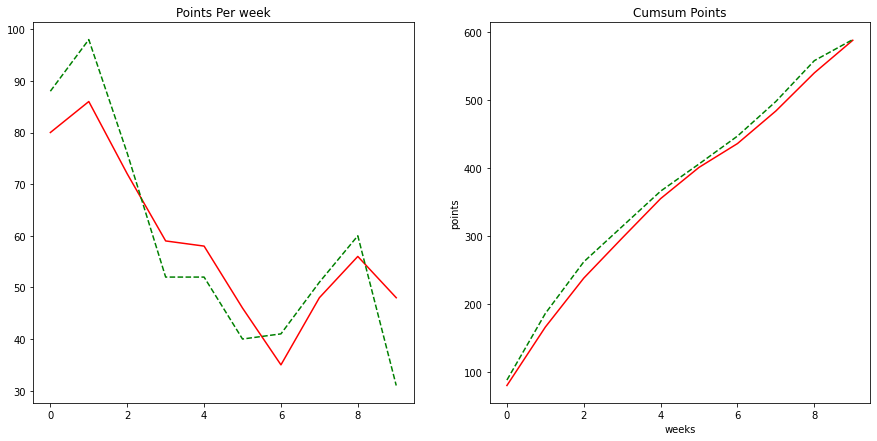

actually_better_plots : 1


[589.0]

In [32]:
epsilon = 0.1
gamma = 1.0

n_episode = 10000     # number of episodes
max_steps = 1000  # maximum steps for each episode
lr = 1e-3
epsilon_iter_delta = 200 # this needs to be high . need more exploration 



checkpoint = torch.load(model_saved_path)
# network_eval = InvPendNet(4,2)
network_eval = RecruiterNetwork(N_states + current_week, possible_actions.shape[1])
network_eval.load_state_dict(checkpoint)
network_eval.eval()
network_eval.cuda()

env = FPLSimulator(current_week, fpl_manager_id, req_cols=['stats.ict_index','element_type'], balance = balance)

observation = env.reset()
episode = []
G_all = []
optimizer = optim.Adam(network.parameters(), lr=lr)

for t in range(current_week):
  scout = Scout(env, t, min_balance, env.balance, K)

  s = observation
  a, action_idx = epsilon_greedy_action(env, s, network_eval, epsilon, t)
  # a, action_idx = random_action() 
  observation, r, done = env.step(action_idx, t, scout)
  # s_prime = observation
  episode.append([s,action_idx,r])
  # print('episode {}, game week {}'.format(i_episode, t))
  if done:
    break
# more_episodes = generate_episodes(env, episode)

G_all = calculate_episode_return(episode,gamma)
loss,out,gt = update_Q_value(G_all, episode, network_eval, optimizer)

logging.info(' ::::: Evaluation ::::')

logging.info('{} # {}, epsilon {},return {}, out {}, Y {} loss : {}'.format(datetime.now(), 0 , epsilon, G_all[0], out.mean(), gt.mean(), loss))
print('{} # {}, epsilon {},return {}, out {}, Y {} loss : {}'.format(datetime.now(), 0 , epsilon, G_all[0], out.mean(), gt.mean(), loss))

proj = np.array(env.transfers_in_episode).sum(axis=1)
env.sample_visualization(1,[proj], file_save = './plots/recruiter_mgr_id_{}.png'.format(fpl_manager_id))

In [16]:
[e[1] for e in episode]

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4]

In [17]:
env.actual_players_ids

array([[ 30,  30,  30,  69,  69,  69,  69,  69, 376, 376],
       [275, 275, 237, 237, 275, 237, 127, 208, 491, 491],
       [418, 245, 418, 418, 418, 418, 418, 119, 208, 418],
       [237, 237, 275, 275, 245, 275, 122, 256, 256, 256],
       [233, 233, 359, 196, 145, 196, 196, 419, 141, 208],
       [215, 215, 233, 233, 289, 233, 233, 289, 289, 141],
       [289, 289, 419, 419, 196, 289, 289, 196, 196, 196],
       [485, 485, 289, 289, 233, 419, 419, 233, 233, 233],
       [413, 413, 413, 413, 419, 413, 413, 307, 307, 307],
       [337, 337, 337, 579, 189, 579, 579, 413, 413, 413],
       [177, 177, 177, 177, 579, 307, 307, 579, 579, 579],
       [376, 376, 376, 376, 376, 376, 376, 376,  69,  69],
       [245, 418, 208, 145, 413, 145, 145, 418, 119, 119],
       [208, 208, 145, 208, 208, 245, 245, 145, 418, 145],
       [145, 145, 245, 245, 237, 208, 208, 122, 145, 289]])

In [18]:
proj.sum(axis=0)

array([[  0., 353.,   0., 143., 559.,   0.,   0., 143.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [ 80.,   0., 270.,   0.,   0., 475., 314.,   0., 408., 559.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   

In [19]:
env.running_player_ids

array([[ 30, 353, 353, 143, 559, 559, 559, 143, 143, 143],
       [275, 275, 275, 275, 275, 275, 275, 275, 275, 275],
       [418, 418, 418, 418, 418, 418, 418, 418, 418, 418],
       [237, 237, 237, 237, 237, 237, 237, 237, 237, 237],
       [233, 233, 233, 233, 233, 233, 233, 233, 233, 233],
       [215, 215, 215, 215, 215, 215, 215, 215, 215, 215],
       [289, 289, 289, 289, 289, 289, 289, 289, 289, 289],
       [485, 485, 485, 485, 485, 485, 485, 485, 485, 485],
       [413, 413, 413, 413, 413, 413, 413, 413, 413, 413],
       [337, 337, 337, 337, 337, 337, 337, 337, 337, 337],
       [177, 177, 177, 177, 177, 177, 177, 177, 177, 177],
       [ 80,  80, 270, 270, 270, 475, 314, 314, 408, 559],
       [245, 245, 245, 245, 245, 245, 245, 245, 245, 245],
       [208, 208, 208, 208, 208, 208, 208, 208, 208, 208],
       [145, 145, 145, 145, 145, 145, 145, 145, 145, 145]])

In [20]:
original_cum_points = np.cumsum(env.actual_players_points.sum(axis=0))
new_cum_points = np.cumsum(env.running_player_points.sum(axis=0))
original_cum_points , new_cum_points

(array([ 80., 166., 238., 297., 355., 401., 436., 484., 540., 588.]),
 array([ 88., 186., 262., 314., 366., 406., 447., 503., 563., 594.]))